## Active Learning on  3 Class Problem

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import sys, os, imp

In [3]:
imp.load_source('activelearn', '../activelearn.py')

<module 'activelearn' from '../activelearn.pyc'>

In [4]:
from activelearn import *

In [115]:
import numpy as np
from keras.preprocessing import sequence
from keras.preprocessing import text

class loader(object):
    def __init__(self, init_seed, maxlen, nb_words, skip_top, test_split):
        self.start_char = 1
        self.oov_char = 2
        self.index_from = 3
        
        label_type = '/label.4class.' # '/rating.'
        
        data_dir = "datasets/scale_data/scaledata/"
        files = ["Dennis+Schwartz", "James+Berardinelli", "Scott+Renshaw", "Steve+Rhodes"]
        texts, ratings = [], []
        for file in files:
            with open(data_dir + file + "/subj." + file, "r") as f:
                texts += list(f)
            with open(data_dir + file + label_type + file, "r") as f:
                ratings += list(f)
        tokenizer = text.Tokenizer(filters='')
        tokenizer.fit_on_texts(texts)
        X = tokenizer.texts_to_sequences(texts)
        Y = [float(rating) for rating in ratings]

        # Shuffle data:
        np.random.seed(init_seed)
        np.random.shuffle(X)
        np.random.seed(init_seed)
        np.random.shuffle(Y)

        # Parse data
        X = [[self.start_char] + [w + self.index_from for w in x] for x in X]

        new_X = []
        new_Y = []
        for x, y in zip(X, Y):
            for i in xrange(0, len(x), maxlen):
                new_X.append(x[i:i+maxlen])
                new_Y.append(y)
        X = new_X
        Y = new_Y

        # by convention, use 2 as OOV word
        # reserve 'index_from' (=3 by default) characters: 0 (padding), 1 (start), 2 (OOV)
        X = [[self.oov_char if (w >= nb_words or w < skip_top) else w for w in x] for x in X]

        self.X_train = X[:int(len(X)*(1-test_split))]
        self.Y_train = Y[:int(len(X)*(1-test_split))]
        self.mean_y_train = np.mean(self.Y_train)
        self.std_y_train = np.std(self.Y_train)
        #self.Y_train = [(y - self.mean_y_train) / self.std_y_train for y in self.Y_train]

        self.X_test = X[int(len(X)*(1-test_split)):]
        self.Y_test = Y[int(len(X)*(1-test_split)):]

        print(len(self.X_train), 'train sequences')
        print(len(self.X_test), 'test sequences')

        print("Pad sequences (samples x time)")
        self.X_train = sequence.pad_sequences(self.X_train, maxlen=maxlen)
        self.X_test = sequence.pad_sequences(self.X_test, maxlen=maxlen)
        print('X_train shape:', self.X_train.shape)
        print('X_test shape:', self.X_test.shape)

In [116]:
p_W, p_U, p_dense, p_emb, weight_decay, batch_size, maxlen = ["0.25", "0.25", "0.25", "0.25", "1e-4", "128", "200"]
batch_size = int(batch_size)
maxlen = int(maxlen)
#folder = "/scratch/home/Projects/rnn_dropout/exps/"

# Global params:
nb_words = 20000
skip_top = 0
test_split = 0.2
init_seed = 1
global_seed = 0

num_classes = 4

In [117]:
# Load data:
print("Loading data...")
dataset = loader(init_seed, maxlen, nb_words, skip_top, test_split)

Loading data...
(10620, 'train sequences')
(2655, 'test sequences')
Pad sequences (samples x time)
('X_train shape:', (10620, 200))
('X_test shape:', (2655, 200))


In [118]:
X_train, X_test, Y_train, Y_test = dataset.X_train, dataset.X_test, dataset.Y_train, dataset.Y_test

X_train = np.asarray(X_train)
X_test  = np.asarray(X_test)
Y_train = np.asarray(Y_train)
Y_test  = np.asarray(Y_test)

In [122]:
np.sum(Y_train == 0.0)

1337

In [123]:
from keras.optimizers import SGD, RMSprop, Adagrad
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.regularizers import l2

In [124]:
Y_train_1hot = np.zeros([Y_train.shape[0], num_classes])
Y_train_1hot[Y_train==0] = [1,0,0,0]
Y_train_1hot[Y_train==1] = [0,1,0,0]
Y_train_1hot[Y_train==2] = [0,0,1,0]
Y_train_1hot[Y_train==3] = [0,0,0,1]


Y_test_1hot = np.zeros([Y_test.shape[0], num_classes])
Y_test_1hot[Y_test==0] = [1,0,0,0]
Y_test_1hot[Y_test==1] = [0,1,0,0]
Y_test_1hot[Y_test==2] = [0,0,1,0]
Y_test_1hot[Y_test==3] = [0,0,1,0]

In [132]:
# Build model:
print('Build model...')
model = Sequential()
model.add(Embedding(nb_words + dataset.index_from, 100, embeddings_regularizer=l2(weight_decay), 
                    input_length=maxlen)) # batch_input_shape=(batch_size, maxlen)

model.add(SpatialDropout1D(p_emb))

#model.add(LSTM(128, W_regularizer=l2(weight_decay), U_regularizer=l2(weight_decay),
#               b_regularizer=l2(weight_decay), dropout_W=p_W, dropout_U=p_U))

model.add(LSTM(128, dropout=p_U, recurrent_dropout=p_W))

model.add(Dropout(p_dense))
#model.add(Dense(4, W_regularizer=l2(weight_decay), b_regularizer=l2(weight_decay)))
model.add(Dense(4, activation='sigmoid'))

#optimiser = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=False)
optimiser = 'adam'
model.compile(loss='mean_squared_error', optimizer=optimiser)

# Potentially load weights
# model.load_weights("path")

Build model...


In [133]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 100)          2000300   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 200, 100)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 516       
Total params: 2,118,064
Trainable params: 2,118,064
Non-trainable params: 0
_________________________________________________________________


In [134]:
tensorflow_train_size = batch_size * (len(X_train) / batch_size)
model.fit(X_train[:tensorflow_train_size], np.array(Y_train_1hot[:tensorflow_train_size]),
           batch_size=batch_size, epochs=15)#, callbacks=[modeltest_1, modeltest_2])

# Potentially save weights
# model.save_weights("path", overwrite=True)

Epoch 1/15
10496/10496 [==============================] - 35s 3ms/step - loss: 0.2168
Epoch 2/15
10496/10496 [==============================] - 35s 3ms/step - loss: 0.1774
Epoch 3/15
10496/10496 [==============================] - 34s 3ms/step - loss: 0.1769
Epoch 4/15
10496/10496 [==============================] - 33s 3ms/step - loss: 0.1767
Epoch 5/15
10496/10496 [==============================] - 34s 3ms/step - loss: 0.1765
Epoch 6/15
10496/10496 [==============================] - 34s 3ms/step - loss: 0.1761
Epoch 7/15
10496/10496 [==============================] - 34s 3ms/step - loss: 0.1738
Epoch 8/15
10496/10496 [==============================] - 34s 3ms/step - loss: 0.1699
Epoch 9/15
10496/10496 [==============================] - 34s 3ms/step - loss: 0.1653
Epoch 10/15
10496/10496 [==============================] - 34s 3ms/step - loss: 0.1574
Epoch 11/15
10496/10496 [==============================] - 34s 3ms/step - loss: 0.1591
Epoch 12/15
10496/10496 [===========================

In [135]:
# Evaluate model
# Dropout approximation for training data:
train_prob = model.predict(X_train, batch_size=128, verbose=1)
np.sum(np.argmax(train_prob, axis=1) == Y_train)*1.0/Y_train.shape[0]

10620/10620 [==============================] - 6s 538us/step


0.83502824858757063

In [136]:
# Dropout approximation for test data:
test_prob = model.predict(X_test, batch_size=500, verbose=1)
np.sum(np.argmax(test_prob, axis=1) == Y_test)*1.0/Y_test.shape[0]

2655/2655 [==============================] - 0s 153us/step


0.43427495291902074

## Keras IMBD Dataset

In [1]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

Using TensorFlow backend.


In [2]:
max_features = 20000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

In [3]:
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
(25000, 'train sequences')
(25000, 'test sequences')


In [354]:
X_train = x_train[:500]
Y_train = y_train[:500]

X_test = x_test[:5000]
Y_test = y_test[:5000]

# Pool is the unsupervised dataset
x_pool = x_train[10000:20000]
y_pool = y_train[10000:20000]

In [356]:
print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)

X_pool = sequence.pad_sequences(x_pool, maxlen=maxlen)
Y_pool = y_pool
print('x_pool shape:', X_pool.shape)

Pad sequences (samples x time)
('x_train shape:', (500, 80))
('x_test shape:', (5000, 80))
('x_pool shape:', (10000, 80))


In [309]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

Build model...


In [310]:
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [311]:
print('Train...')
model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=3,
          validation_data=(X_test, Y_test))


Train...
Train on 500 samples, validate on 5000 samples
Epoch 1/3
500/500 [==============================] - 10s 21ms/step - loss: 0.6931 - acc: 0.4860 - val_loss: 0.6911 - val_acc: 0.5570
Epoch 2/3
500/500 [==============================] - 8s 15ms/step - loss: 0.6703 - acc: 0.7440 - val_loss: 0.6613 - val_acc: 0.6110
Epoch 3/3
500/500 [==============================] - 8s 15ms/step - loss: 0.5603 - acc: 0.8500 - val_loss: 0.6408 - val_acc: 0.6368


In [169]:
score, acc = model.evaluate(X_test, Y_test, batch_size=batch_size)

print('Test score:', score)
print('Test accuracy:', acc)

5000/5000 [==============================] - 5s 1ms/step
('Test score:', 0.49929289445877073)
('Test accuracy:', 0.80640000000000001)


In [147]:
score, acc = model.evaluate(X_test, Y_test, batch_size=batch_size)

print('Test score:', score)
print('Test accuracy:', acc)

5000/5000 [==============================] - 9s 2ms/step
('Test score:', 1.008508877468109)
('Test accuracy:', 0.6714)


### Active Learning Procedure
1. Allocate an unsupervised set and a test set
2. Initially pick some (say 100) from the unsupervised set, get the labels and set it as the train set
3. Iterate: pick 10 (vary this parameter) most promising from the unsupervised and add to the train set - retrain

In [330]:
import sys, os, imp
imp.load_source('activelearn', '../activelearn.py')
from activelearn import *

In [528]:
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Flatten, Embedding
from keras.models import Model
from keras import Sequential
from keras.preprocessing import sequence
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

In [523]:
# Pool is the unsupervised dataset
x_pool = x_train[5000:15000]
y_pool = y_train[5000:15000]

X_pool = sequence.pad_sequences(x_pool, maxlen=maxlen)
Y_pool = y_pool
print('x_pool shape:', X_pool.shape)

batch_size = 128

('x_pool shape:', (10000, 80))


In [471]:
y_train.shape

(25020,)

In [524]:
def init_pick(pool_data, pool_labels, num):
    '''Pick num number of datapoints from the unsupervised data pool
    Remove them from the pool and return the data.
    Returns chosen datapoints and the updated pool_data'''
    if len(pool_data) < num:
        raise Exception('pool data is too small')
        
    np.random.seed(0)
    indices = np.random.choice(range(len(pool_data)), num, replace=False)
    datapoints = pool_data[indices]
    labels = pool_labels[indices]
    pool_data = np.delete(pool_data, indices, axis=0)
    pool_labels = np.delete(pool_labels, indices, axis=0)
    print("Picked " + str(num) + " datapoints\nSize of updated unsupervised pool = " + str(len(pool_data)) + "\n")
    return datapoints, labels, pool_data, pool_labels

def active_pick(acq_fn, num_samples, pool_data, pool_labels, pool_subset_count = 2000):
    """Inputs: Unsupervised data, an acquisition function and number of samples to return
    Output: The datapoints from unsupervised data which has the highest value as per the acquisition function
    """
    #unsup_data = np.array(unsup_data)
    if len(pool_data) < num_samples:
        raise Exception('pool data is exhausted')
        
    if pool_subset_count > len(pool_data):
        pool_subset_count = len(pool_data)

    #values = [acq_fn(x) for x in pool_data]
    pool_subset_random_index = np.random.choice(range(len(pool_data)), pool_subset_count, replace=False)
    X_pool_subset = pool_data[pool_subset_random_index]
    y_pool_subset = pool_labels[pool_subset_random_index]

    print('Search over Pool of Unlabeled Data')

    values = acq_fn(X_pool_subset)
    pos = np.argpartition(values, -num_samples)[-num_samples:]
    datapoints = X_pool_subset[pos]
    labels = y_pool_subset[pos]
    #print pool_subset_random_index[:10]
    pool_data = np.delete(pool_data, (pool_subset_random_index[pos]), axis=0)
    pool_labels = np.delete(pool_labels, (pool_subset_random_index[pos]), axis=0)
    print("Picked " + str(num_samples) + " datapoints\nSize of updated Unsupervised pool = " + str(len(pool_data)))

    return datapoints, labels, pool_data, pool_labels

def var_ratio(pool_data):
    # Var ratio active learning acquisition function
    # D_probs - Deterministic probs as opposed to MC sampling
    D_probs = model.predict_proba(pool_data)  
    return 1.0 - np.max(D_probs, axis=1)

def random_acq(pool_data):
    return np.random.rand(len(pool_data))

In [542]:
# Initially
X_train, Y_train, X_pool, Y_pool = init_pick(X_pool, Y_pool, 100)

Picked 100 datapoints
Size of updated unsupervised pool = 7100



In [526]:
X_pool.shape

(9900, 80)

In [543]:
results = []
# Initial training
print('Build model...')
#model = Sequential()
#model.add(Embedding(max_features, 128))
#model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
#model.add(Dense(1, activation='sigmoid'))
model = Sequential()
model.add(Embedding(max_features, 100, input_length=maxlen))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(X_train, Y_train, batch_size=batch_size, epochs=3) #, validation_data=(X_test, Y_test))

score, acc = model.evaluate(X_test, Y_test, batch_size=batch_size)
#print('Test score:', score)
print('Test accuracy:', acc)
results.append((X_train.shape[0], acc))

Build model...
Train...
Epoch 1/3
100/100 [==============================] - 10s 105ms/step - loss: 0.6885 - acc: 0.5900
Epoch 2/3
100/100 [==============================] - 0s 71us/step - loss: 0.6639 - acc: 0.6100
Epoch 3/3
5000/5000 [==============================] - 5s 932us/step
('Test accuracy:', 0.48580000000000001)


In [531]:
results

[(100, 0.49580000000000002)]

In [466]:
import timeit
timeit.time.time()

1516319308.311072

In [544]:
start = timeit.time.time()
acquisition_iterations = 100
for i in range(acquisition_iterations):
    print('\n\nACQUISITION ITERATION ' + str(i+1) + ' of ' + str(acquisition_iterations))
    
    X_picked, Y_picked, X_pool, Y_pool = active_pick(random_acq, 10, X_pool, Y_pool)
    print('Acquired Points added to the training set')
    X_train = np.concatenate((X_train, X_picked), axis=0)
    Y_train = np.concatenate((Y_train, Y_picked), axis=0)
    print('Train Data size: ' + str(X_train.shape))  
    print('Unlabeled Pool size: ' + str(X_pool.shape))

    print('Train Again with the added points')

    model.fit(X_train, Y_train, batch_size=batch_size, epochs=5) #, validation_data=(X_test, Y_test))

    score, acc = model.evaluate(X_test, Y_test, batch_size=batch_size)
    #print('Test score:', score)
    print('Test accuracy:', acc)
    results.append((X_train.shape[0], acc))

end = timeit.time.time()
print('\n Total time = ' + str(end-start) + 's')



ACQUISITION ITERATION 1 of 100
Search over Pool of Unlabeled Data
Picked 10 datapoints
Size of updated Unsupervised pool = 7090
Acquired Points added to the training set
Train Data size: (110, 80)
Unlabeled Pool size: (7090, 80)
Train Again with the added points
Epoch 1/5
110/110 [==============================] - 0s 163us/step - loss: 0.6193 - acc: 0.6273
Epoch 2/5
110/110 [==============================] - 0s 68us/step - loss: 0.5935 - acc: 0.6636
Epoch 3/5
110/110 [==============================] - 0s 67us/step - loss: 0.5666 - acc: 0.7636
Epoch 4/5
110/110 [==============================] - 0s 75us/step - loss: 0.5385 - acc: 0.8364
Epoch 5/5
5000/5000 [==============================] - 0s 26us/step
('Test accuracy:', 0.48580000000000001)


ACQUISITION ITERATION 2 of 100
Search over Pool of Unlabeled Data
Picked 10 datapoints
Size of updated Unsupervised pool = 7080
Acquired Points added to the training set
Train Data size: (120, 80)
Unlabeled Pool size: (7080, 80)
Train Again wit

Epoch 5/5
5000/5000 [==============================] - 0s 24us/step
('Test accuracy:', 0.49559999999999998)


ACQUISITION ITERATION 11 of 100
Search over Pool of Unlabeled Data
Picked 10 datapoints
Size of updated Unsupervised pool = 6990
Acquired Points added to the training set
Train Data size: (210, 80)
Unlabeled Pool size: (6990, 80)
Train Again with the added points
Epoch 1/5
210/210 [==============================] - 0s 71us/step - loss: 0.0351 - acc: 0.9857
Epoch 2/5
210/210 [==============================] - 0s 96us/step - loss: 0.0269 - acc: 0.9905
Epoch 3/5
210/210 [==============================] - 0s 99us/step - loss: 0.0183 - acc: 0.9952
Epoch 4/5
210/210 [==============================] - 0s 62us/step - loss: 0.0122 - acc: 1.0000
Epoch 5/5
5000/5000 [==============================] - 0s 21us/step
('Test accuracy:', 0.49859999999999999)


ACQUISITION ITERATION 12 of 100
Search over Pool of Unlabeled Data
Picked 10 datapoints
Size of updated Unsupervised pool = 6980
Acquire

400/400 [==============================] - 0s 72us/step - loss: 0.0222 - acc: 0.9875
Epoch 2/5
400/400 [==============================] - 0s 73us/step - loss: 0.0064 - acc: 1.0000
Epoch 3/5
400/400 [==============================] - 0s 84us/step - loss: 0.0015 - acc: 1.0000
Epoch 4/5
400/400 [==============================] - 0s 84us/step - loss: 8.9111e-04 - acc: 1.0000
Epoch 5/5
5000/5000 [==============================] - 0s 22us/step
('Test accuracy:', 0.54479999999999995)


ACQUISITION ITERATION 31 of 100
Search over Pool of Unlabeled Data
Picked 10 datapoints
Size of updated Unsupervised pool = 6790
Acquired Points added to the training set
Train Data size: (410, 80)
Unlabeled Pool size: (6790, 80)
Train Again with the added points
Epoch 1/5
410/410 [==============================] - 0s 65us/step - loss: 0.0191 - acc: 0.9878
Epoch 2/5
410/410 [==============================] - 0s 90us/step - loss: 0.0034 - acc: 1.0000
Epoch 3/5
410/410 [==============================] - 0s 78us/s

500/500 [==============================] - 0s 72us/step - loss: 0.0227 - acc: 0.9900
Epoch 2/5
500/500 [==============================] - 0s 95us/step - loss: 0.0051 - acc: 0.9980
Epoch 3/5
500/500 [==============================] - 0s 72us/step - loss: 7.4898e-04 - acc: 1.0000
Epoch 4/5
500/500 [==============================] - 0s 80us/step - loss: 6.7654e-04 - acc: 1.0000
Epoch 5/5
5000/5000 [==============================] - 0s 25us/step
('Test accuracy:', 0.55220000000000002)


ACQUISITION ITERATION 41 of 100
Search over Pool of Unlabeled Data
Picked 10 datapoints
Size of updated Unsupervised pool = 6690
Acquired Points added to the training set
Train Data size: (510, 80)
Unlabeled Pool size: (6690, 80)
Train Again with the added points
Epoch 1/5
510/510 [==============================] - 0s 58us/step - loss: 0.0130 - acc: 0.9941
Epoch 2/5
510/510 [==============================] - 0s 62us/step - loss: 0.0022 - acc: 1.0000
Epoch 3/5
510/510 [==============================] - 0s 69

('Test accuracy:', 0.53300000000000003)


ACQUISITION ITERATION 50 of 100
Search over Pool of Unlabeled Data
Picked 10 datapoints
Size of updated Unsupervised pool = 6600
Acquired Points added to the training set
Train Data size: (600, 80)
Unlabeled Pool size: (6600, 80)
Train Again with the added points
Epoch 1/5
600/600 [==============================] - 0s 92us/step - loss: 0.0239 - acc: 0.9917
Epoch 2/5
600/600 [==============================] - 0s 70us/step - loss: 7.5495e-04 - acc: 1.0000
Epoch 3/5
600/600 [==============================] - 0s 80us/step - loss: 3.8879e-04 - acc: 1.0000
Epoch 4/5
600/600 [==============================] - 0s 91us/step - loss: 4.3224e-04 - acc: 1.0000
Epoch 5/5
5000/5000 [==============================] - 0s 24us/step
('Test accuracy:', 0.49619999999999997)


ACQUISITION ITERATION 51 of 100
Search over Pool of Unlabeled Data
Picked 10 datapoints
Size of updated Unsupervised pool = 6590
Acquired Points added to the training set
Train Data size: (610

790/790 [==============================] - 0s 70us/step - loss: 0.0127 - acc: 0.9924
Epoch 2/5
790/790 [==============================] - 0s 77us/step - loss: 1.5659e-04 - acc: 1.0000
Epoch 3/5
790/790 [==============================] - 0s 70us/step - loss: 1.0755e-04 - acc: 1.0000
Epoch 4/5
790/790 [==============================] - 0s 102us/step - loss: 9.8475e-05 - acc: 1.0000
Epoch 5/5
5000/5000 [==============================] - 0s 22us/step
('Test accuracy:', 0.57099999999999995)


ACQUISITION ITERATION 70 of 100
Search over Pool of Unlabeled Data
Picked 10 datapoints
Size of updated Unsupervised pool = 6400
Acquired Points added to the training set
Train Data size: (800, 80)
Unlabeled Pool size: (6400, 80)
Train Again with the added points
Epoch 1/5
800/800 [==============================] - 0s 71us/step - loss: 0.0062 - acc: 0.9975
Epoch 2/5
800/800 [==============================] - 0s 83us/step - loss: 1.6766e-04 - acc: 1.0000
Epoch 3/5
800/800 [==============================

980/980 [==============================] - 0s 67us/step - loss: 8.1788e-05 - acc: 1.0000
Epoch 3/5
980/980 [==============================] - 0s 72us/step - loss: 6.7173e-05 - acc: 1.0000
Epoch 4/5
980/980 [==============================] - 0s 90us/step - loss: 6.3849e-05 - acc: 1.0000
Epoch 5/5
5000/5000 [==============================] - 0s 30us/step
('Test accuracy:', 0.61099999999999999)


ACQUISITION ITERATION 89 of 100
Search over Pool of Unlabeled Data
Picked 10 datapoints
Size of updated Unsupervised pool = 6210
Acquired Points added to the training set
Train Data size: (990, 80)
Unlabeled Pool size: (6210, 80)
Train Again with the added points
Epoch 1/5
990/990 [==============================] - 0s 85us/step - loss: 0.0109 - acc: 0.9949
Epoch 2/5
990/990 [==============================] - 0s 73us/step - loss: 1.5509e-04 - acc: 1.0000
Epoch 3/5
990/990 [==============================] - 0s 74us/step - loss: 1.3708e-04 - acc: 1.0000
Epoch 4/5
990/990 [===========================

In [557]:
a1 = [v[1] for v in cnn_var1][:-1]
a2 = [v[1] for v in cnn_var2][:-1]
r = [v[1] for v in cnn_rand1][:-1]

In [558]:
a = np.mean([a1, a2], axis=0)

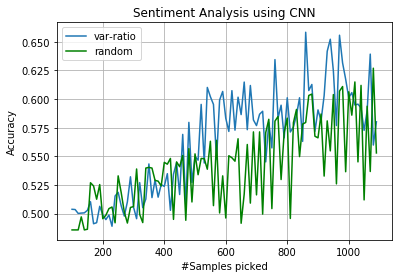

In [560]:
plt.plot(x_axis, a, label='var-ratio')
plt.plot(x_axis, r, 'g', label='random')
plt.grid()
plt.xlabel('#Samples picked')
plt.ylabel('Accuracy')
plt.title('Sentiment Analysis using CNN')
plt.legend(loc=0)
plt.show()


In [547]:
#t1 = np.load('var1.npy')
#t2 = np.load('var2.npy')
#t3 = np.load('rand1.npy')

a1 = [cnn_var1[i] for i in range(100, 1100, 10)] 
a2 = [cnn_var2[i] for i in range(100, 1100, 10)] 
r1 = [cnn_rand1[i] for i in range(100, 1100, 10)] 

a = np.mean([a1, a2], axis=0)
r = r1#np.mean([r1, r2, r3, r4, r5], axis=0)

IndexError: list index out of range

In [517]:
x_axis = np.array(range(100, 1100, 10))

In [518]:
len(x_axis)

100

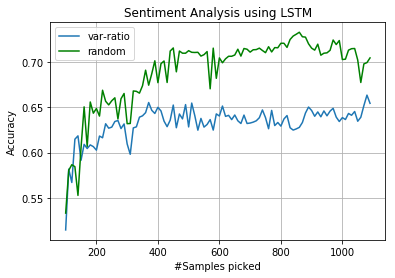

In [520]:
#plt.axis([0, 1100, 0.8, 1])
#plt.yticks(np.array(range(11))*0.02 + 0.8)
#plt.xticks(np.array(range(10))*100)
#plt.plot(np.array(range(99))*10, a, label='var-ratio')
#plt.plot(np.array(range(99))*10, r, 'g', label='random')
plt.plot(x_axis, a, label='var-ratio')
plt.plot(x_axis, r, 'g', label='random')
plt.grid()
plt.xlabel('#Samples picked')
plt.ylabel('Accuracy')
plt.title('Sentiment Analysis using LSTM')
plt.legend(loc=0)
plt.show()


## Restore imdb’s original text

In [6]:
len(x_train[0])

218

In [17]:
word_to_id = imdb.get_word_index()
word_to_id = {k:(v+3) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in x_train[2] ))

<START> this has to be one of the worst films of the 1990s when my friends i were watching this film being the target audience it was aimed at we just sat watched the first half an hour with our jaws touching the floor at how bad it really was the rest of the time everyone else in the theatre just started talking to each other leaving or generally crying into their popcorn that they actually paid money they had <UNK> working to watch this feeble excuse for a film it must have looked like a great idea on paper but on film it looks like no one in the film has a clue what is going on crap acting crap costumes i can't get across how <UNK> this is to watch save yourself an hour a bit of your life


In [18]:
y_train[2]

0